In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import cv2, imageio, os, imutils, dlib, keras, time, random
from matplotlib import pyplot as plt
from scipy import signal, misc
from sys import getsizeof
import numpy as np
 
import tensorflow as tf
import pandas as pd
from os import walk  
random.seed(0)
from numpy.random import seed

seed(0)
tf.random.set_seed(0)
 
from matplotlib.pyplot import figure
import scipy as sp
# from skimage import transform
 
from numpy import genfromtxt
import keras.backend as K
from keras.backend import resize_images
from keras.models import Sequential, load_model, model_from_json
from keras.layers import SeparableConv2D,DepthwiseConv2D,Input,GlobalMaxPooling2D,GlobalAveragePooling2D,Activation, Conv2D, Conv3D, Reshape, AveragePooling3D, AveragePooling2D, GlobalAveragePooling3D,GlobalAveragePooling2D,GlobalAveragePooling1D, MaxPooling2D, LSTM, Embedding, Dense, Dropout, Flatten
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import TimeDistributed
from keras.utils.training_utils import multi_gpu_model
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenetv2 import MobileNetV2
# keras.applications.inception_resnet_v2.InceptionResNetV2
from keras.applications.xception import Xception
from keras.models import Model
 
from PIL import Image
from imutils import face_utils
from PIL import Image
 
# Just disables the warning generated by tf, doesn't enable AVX/FMA
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
 
frame_size = [224,224]
ecg_sr = 250
 
path = r'PATH' 
video_path = path + 'VIDEO.mp4'
ecg_path = path + 'ECG_FILE.csv' # 
timestamp_path = path + 'VIDEO_FRAME_timestamp.csv'# timestamp of each frame in the video
config_path = path + 'CONFIG.txt'

Using TensorFlow backend.


In [ ]:
# ## Convert video to frames
# vidcap = cv2.VideoCapture(video_path)
# length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
# fps = vidcap.get(cv2.CAP_PROP_FPS)
# print('##fps: ', fps, length)
# success,image = vidcap.read()
# count = 0
# frame_no = 5000
# while success:
#     cv2.imwrite(path + "/frame%d.jpg" % count, image)     # save frame as JPEG file    
#     success,image = vidcap.read()
#     if(count % 100 == 0):
#         print('Read a new frame: ', success, count)
#     count += 1
#     if(count > frame_no):
#         break

In [ ]:
## load the config info to time-sync for each experiment session
## time_gap, video_t0, ecg_t0, start_frame, end_frame
config = np.genfromtxt(config_path, delimiter=' ')
time_gap = config[0]
vid_t0 = config[1]
ecg_t0 = config[2]
ecg_t0 = ecg_t0 - gap
ecg_t0 = ecg_t0 - vid_t0 # using frame_timestamps directly, with ecg_hz
frame_range = [int(config[3]), int(config[4])]
gap, vid_t0, ecg_t0, frame_range

# 새 섹션

In [ ]:
## read ecg file, skip the first row
ecg = np.genfromtxt(ecg_path, delimiter=',')
ecg = ecg[1:]
## read video frame-timestamp file
frame_timestamps = np.genfromtxt(timestamp_path, delimiter=',')*1000

In [ ]:
## map vid_frame to ecg_datapoint
ecg_indices = ((frame_timestamps[frame_range[0]:frame_range[1]] - ecg_t0 )/4 + 0.5).astype(int)
peak_indices = signal.find_peaks(ecg[ecg_indices[0]-250:ecg_indices[-1],1], distance=130)[0] + ecg_indices[0]-250   

for i in range(len(peak_indices)-1):
    index = peak_indices[i]
    next_index = peak_indices[i+1]
    interval = next_index - index
    for j in range(index, next_index,1):
        ecg[j,0] = (j-index)*4

labels = np.zeros((len(ecg_indices),17))
for i in range(17):
    ## horizontal/time axis
    labels[:,i] = ecg[ecg_indices+i-8,0]

In [ ]:
## convert video to numpy file
images = np.zeros((frame_range[1]-frame_range[0], frame_size[0], frame_size[1]), dtype=np.float32)
vidcap = cv2.VideoCapture(video_path)
length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = vidcap.get(cv2.CAP_PROP_FPS)
print('##fps: ', fps, length)
success,image = vidcap.read()
count = 0
while success:
    if((count >= frame_range[0]) & (count < frame_range[-1])):
        img = Image.fromarray(image[:,:,1])
        img = img.resize(frame_size, Image.ANTIALIAS)
        tmp = np.array(img)/255
        images[count-frame_range[0],:,:] = tmp[:,:]

    success,image = vidcap.read()
    if(count % 100 == 0):
        print('Read a new frame: ', success, count)
    count += 1

np.save(path + '/image224_15f.npy',images)

In [ ]:
### face detection #############
#         cv2.imwrite(path + "/frames/frame%d.jpg" % count, image[:,:-300])
#         image = image[:,:-300]
#         image = np.transpose(image, (1,0,2))
#         image = np.flip(image, axis = 0)
#         gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         # detect faces in the grayscale frame
#         rects = detector(gray_img, 0)
        
#         if(len(rects) == 1):
#             for rect in rects:
#                 # compute the bounding box of the face and draw it on the frame
#                 (bX, bY, bW, bH) = face_utils.rect_to_bb(rect)
#                 shape = predictor(gray_img, rect)
#                 shape = face_utils.shape_to_np(shape)
#             print(count, len(rects),"###",bX, bY, bW, bH)
            
#             pad_W = int(0.1*bW)
#             pad_H = int(0.25*bH)
#             bY = np.max([0, bY-pad_H])
#             bX = np.max([0, bX-pad_W])
#             bH = bH+2*pad_H
#             bW = bW+2*pad_W
            
#         print(count,"@@@",bX, bY, bW, bH)
#         shapes[count-frame_range[0],:,:] = shape
            
#         image = image[(bY):(bY+bH),(bX):(bX+bW),:]

In [ ]:
np.save(path + '/image224.npy',images )
np.save(path + '/label17.npy', labels)
# images = np.load(path + '/image224.npy')
# labels = np.load(path + '/label.npy')
images.shape, labels.shape

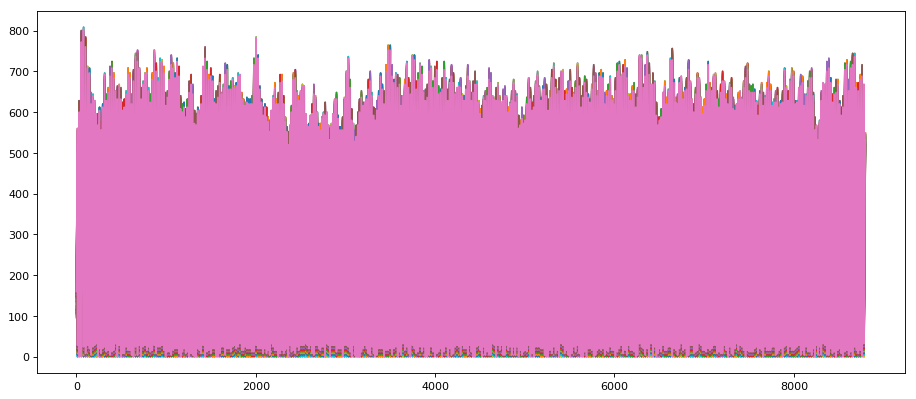

In [ ]:
## interbeat-interval plot
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(labels[:]);

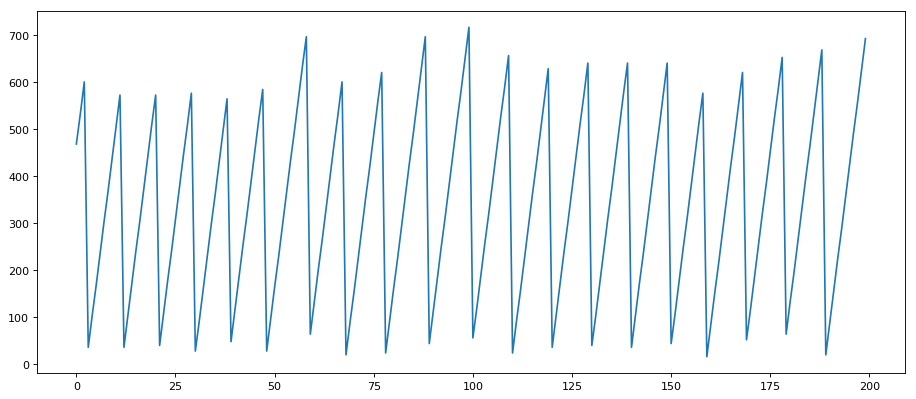

In [ ]:
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(labels[range(200,600,2),1]);

In [ ]:
### downsample to 15f
# for video in range(0,4,1):
#     print('video', video+1)
#     images = np.load(path + '/image224_30f_' + str(video+1) + '.npy')
#     labels = np.load(path + '/label17_30f_' + str(video+1) + '.npy')

#     indices = range(0,len(images),2)
#     np.save(path + '/image224_' + str(subject) + '_' + str(video+1) + '.npy',images[indices,:,:])
#     np.save(path + '/label17_' + str(subject) + '_' + str(video+1) + '.npy',labels[indices,:])

video 1
video 2
video 3
video 4


In [ ]:
## normalization
x_train = ((x_train - np.mean(x_train, axis = (1,2,3))[:,None,None,None])/(np.std(x_train, axis = (1,2,3))[:,None,None,None]))
x_val = ((x_val - np.mean(x_val, axis = (1,2,3))[:,None,None,None])/(np.std(x_val, axis = (1,2,3))[:,None,None,None]))

In [ ]:
## Using Inception model
## This could also be the output a different Keras model or layer
frame_size = [224, 224]
input_tensor = Input(shape=(frame_size[0], frame_size[1], channel))  # this assumes K.image_data_format() == 'channels_last'
based_model = InceptionV3(input_tensor=input_tensor, weights=None, include_top=False)

count = 0
for layer in based_model.layers[132:]:
    layer.trainable = False
    count += 1

output_based_model = based_model.layers[132].output
x = AveragePooling2D(pool_size=(2, 2))(output_based_model)
x = Flatten(name='flatten')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', name='fc1')(x)
x = Dense(17)(x)

model = Model(input= based_model.input, output=x)
multigpu_model = multi_gpu_model(model, gpus=2)
base_lr = 0.001
optimizer = keras.optimizers.Adam(lr=base_lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
multigpu_model.compile(loss='mean_absolute_error', optimizer='adam')

print(model.summary())


## Training
# for i in range(201):
#     multigpu_model.fit(x_train, y_train, batch_size=64, epochs=1)

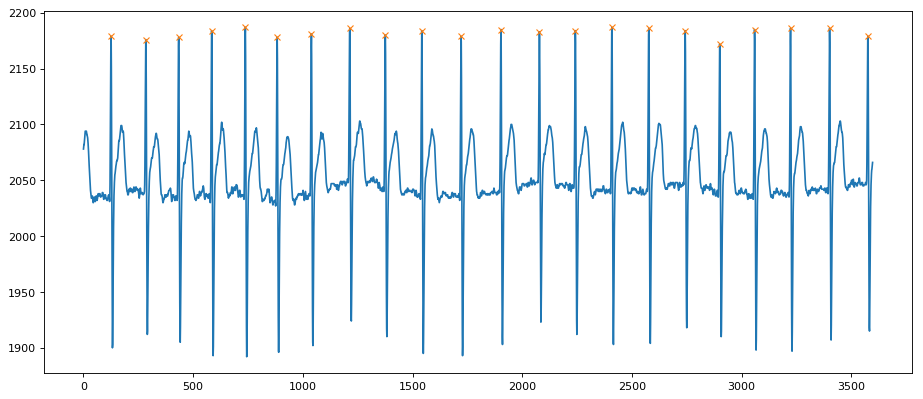

In [ ]:
## visualize to examine ecg waveform
# signal.find_peaks(ecg[ecg_indices[0]-50:ecg_indices[-1],1], distance=120)[0] + ecg_indices[0]-50
tmp = ecg[ecg_indices[200]-250:ecg_indices[600],1]
peak_indices = signal.find_peaks(tmp, distance=130)[0]
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(tmp)
plt.plot(peak_indices,tmp[peak_indices],'x')

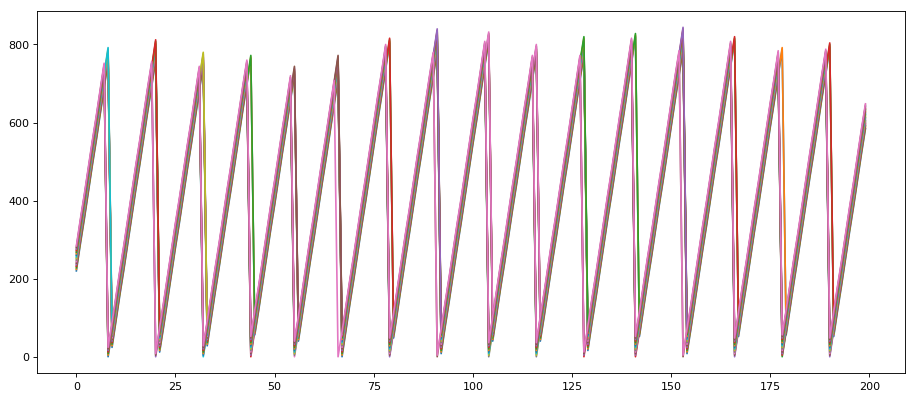

In [ ]:
## visualize the valiation label/ground-truth
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(y_val[:200])